<a href="https://colab.research.google.com/github/zzbn12345/FCIC24_Workshop_AI/blob/main/FCIC_workshop_AI_Social_Media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faro Convention International Conference 2024

## Workshop G02 Artificial Intelligence for Participatory Processes in Heritage Planning
Workshop Leader: Dr. Nan Bai (Wageningen University and Research), Dr. Mahda Foroughi (Delft University of Technology)

### Introduction

This is a Python notebook hosted on Google Colab that you can follow to reproduce many of the results presented during the workshop presentation by Nan and Mahda. You have the chance to bring in your own case-study city and collect your own datasets in ready-to-use formats for further research and heritage investigations. A pipeline from data collection, data processing, feature representation (with pre-trained deep learning models), label classification (with predefined machine learning algorithms), and data visualization will be introduced and followed step-by-step, but in a much easier way.

You probably need some knowledge in programming to understand what happens in each part. However, it does not matter that much if you do not. Just walk through all the steps and you will at least have some interesting results at hand.

After this workshop, you will be able to:
*   understand how social media data can be used to map urban heritage with the help of AI;
*   apply the introduced computational pipeline in their case study of
interest to produce maps;
*   critically analyze and evaluate the meanings, potentials, and limitations of
the methods introduced during the workshop.

Before going on, make sure that you have:
*   made a decision on your own case study area, and collected the geolocation of the area (Latitude $y$, Longitude $x$, and Radius $r$ from the centre); if you do not have one (not recommended), just use the following as default (lat = 41.150505, lon = 8.636225, radius = 0.5), which will collect data from the Faculdade de Arquitectura from the Universidade do Porto;
*   registered an account on Flickr (https://identity.flickr.com/sign-up)
*   applied for an API key from Flickr (https://www.flickr.com/services/apps/create/apply) after signing in;
*   had at hand safely and secretly the key and secret of your applied API;
*   set the api_key and api_secret as "Secrets" in the left panel.

### Basic Settings and Preparations

#### Imports and Installations

In [1]:
!pip install flickrapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.2 MB/s eta 0:00:00


In [80]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.5 MB/s eta 0:00:00


In [81]:
import flickrapi
import json
import pandas as pd
from argparse import Namespace
import urllib
import pickle
import os
from google.colab import userdata
from google.colab import drive
import pathlib
import re
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox

#### Mounting Google Drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After mounting to the Google Drive, you can see its folders by clicking on the Files tab on the left of the Colab notebook. You can also access your downloaded data later.

#### Making a Folder for this Workshop

First tell us how you would love to call your case study city! Please do not use any space in the name. Next time you can also change this case name for another case study that you are interested in.

In [4]:
case_name = 'FAUP_Porto'

Let's make a new folder in your Google Drive for the rest of this project

In [7]:
folder = '/content/drive/MyDrive/FCIC_workshop/' + case_name + '/'
pathlib.Path(folder).mkdir(parents=True, exist_ok=True)

#### User Inputs

In [25]:
args = Namespace(
    # Please paste your API key and secret in your Google Colab environment
    api_key = u'{}'.format(userdata.get('api_key')),
    api_secret = u'{}'.format(userdata.get('api_secret')),
    # Please paste the geolocation of your case study city here
    lat = 41.150505,
    lon = -8.636225,
    # The radius is in the unit of km
    radius = 0.5,
    save_dir = folder + 'data_storage/',
    image_dir = folder + 'data_storage/images/',
    # Set a limit to the images to be collected
    maximum_images = 400,
    tags = None
)

In [19]:
args.save_dir

'/content/drive/MyDrive/FCIC_workshop/FAUP_Porto/data_storage/'

#### Some Pre-defined Functions to be used

In [17]:
def collect_ids(flickr, lat, lon, radius, tags = None):

    if 'photo_ids.csv' in [files for root, dirs, files in os.walk(args.save_dir)][0]:
        Ids = pd.read_csv(args.save_dir+'photo_ids.csv', sep='\t')['ids'].tolist()
    else:
        Ids = []

    walk = flickr.walk(has_geo = 1, lat = args.lat, lon = args.lon, radius = args.radius, tags=args.tags)
    for photo in walk:
        id_now = photo.get('id')
        if id_now in Ids:
            continue
        Ids.append(id_now)
        if len(Ids)%50 == 0:
            print('{} photo ids collected'.format(len(Ids)))
            pd.Series(Ids, name = 'ids').to_csv(args.save_dir + 'photo_ids.csv', index=False)
        if len(Ids)>=args.maximum_images:
          break
    pd.Series(Ids, name = 'ids').to_csv(args.save_dir + 'photo_ids.csv', index=False)
    return Ids

In [18]:
def get_photos(flickr, Photos, Ids):
    processed = Photos.keys()
    for id_now in Ids:
        if id_now in processed:
            continue
        else:
            Photos[id_now] = {}
            sizes = json.loads(flickr.photos.getSizes(photo_id = id_now, format='json'))
            info = json.loads(flickr.photos.getInfo(photo_id = id_now, format='json'))
            try:
                url_c = sizes['sizes']['size'][-2]['source']
                url_q = sizes['sizes']['size'][1]['source']
                can = sizes['sizes']['candownload']
                Photos[id_now]['candownload'] = can
                Photos[id_now]['url_q'] = url_q
                Photos[id_now]['owner'] = info['photo']['owner']['nsid']
                Photos[id_now]['owner_loc'] = info['photo']['owner']['location']
                Photos[id_now]['title'] = info['photo']['title']['_content']
                Photos[id_now]['description'] = info['photo']['description']['_content']
                Photos[id_now]['comments'] = info['photo']['comments']['_content']
                Photos[id_now]['taken'] = info['photo']['dates']['taken']
                Photos[id_now]['views'] = info['photo']['views']
                Photos[id_now]['people'] = info['photo']['people']['haspeople']
                Photos[id_now]['tags'] = info['photo']['tags']['tag']
                Photos[id_now]['lat'] = info['photo']['location']['latitude']
                Photos[id_now]['lon'] = info['photo']['location']['longitude']
                Photos[id_now]['neighbourhood'] = info['photo']['location']['neighbourhood']['_content']
                Photos[id_now]['url'] = info['photo']['urls']['url'][0]['_content']

                if can:
                    urllib.request.urlretrieve(url_q, args.image_dir+'{}.jpg'.format(id_now))

                if len(processed)%50 ==0:
                    print('{}/{} photos collected'.format(len(processed),len(Ids)))
                    with open(args.image_dir+'Photo_sizes.p', 'wb') as fp:
                        pickle.dump(Photos,fp, protocol=pickle.HIGHEST_PROTOCOL)
                    photo_df = pd.DataFrame(Photos).T
                    photo_df.to_csv(args.image_dir+'photos_sizes.csv', sep='\t',encoding='utf-8-sig')
            except:
                print(id_now)
                continue

    with open(args.image_dir+'Photo_sizes.p', 'wb') as fp:
        pickle.dump(Photos,fp, protocol=pickle.HIGHEST_PROTOCOL)
    photo_df = pd.DataFrame(Photos).T
    photo_df.to_csv(args.image_dir+'photos_sizes.csv', sep='\t',encoding='utf-8-sig')
    return Photos

### Data Collection

Colleting the Photo IDs of social media posts that fulfills the requirements within the case study area. This step is very fast (a few seconds).

In [65]:
flickr = flickrapi.FlickrAPI(args.api_key, args.api_secret)
if not 'data_storage' in os.listdir(folder):
  os.mkdir(args.save_dir)
Ids = collect_ids(flickr, args.lat, args.lon, args.radius, args.tags)

50 photo ids collected
100 photo ids collected
150 photo ids collected
200 photo ids collected
250 photo ids collected
300 photo ids collected
350 photo ids collected
400 photo ids collected


Collecting the actual photos with the IDs that has been collected in the last step. This step might take a while (a few minutes).

In [67]:
if not 'images' in os.listdir(args.save_dir):
  os.mkdir(args.image_dir)

if 'Photo_sizes.p' in [files for root, dirs, files in os.walk(args.image_dir)][0]:
  with open(args.image_dir+'Photo_sizes.p', 'rb') as fp:
      Photos = pickle.load(fp)
else:
  Photos = {}
Photos = get_photos(flickr, Photos, Ids)

200/400 photos collected
250/400 photos collected
300/400 photos collected
350/400 photos collected
400/400 photos collected


Congratulations! Now you have your first dataset in your case study city with 400 small-size images! You can check them out in your Google Drive folder "FCIC_workshop/[your_case_study]/data_storage/images".

Since we only have very little time during the workshop, we just collect very few images that might not be representative enough in your area. But you can later increase the number of "maximum_images" to collect more images when you have more time. Note that you might get an error with FlickrAPI because you have called it too many times. Don't worry, just run the last cell again and you will find that the download continues from the last checkpoint, and not from the very beginning ;)!

### Dataset Exploration

#### Downloaded Images

This pandas dataframe contains the collected dataset.

In [68]:
img_df = pd.read_csv(args.image_dir+'photos_sizes.csv',sep='\t').rename(columns={'Unnamed: 0':'ids'})
img_df.head()

,ids,candownload,url_q,owner,owner_loc,title,description,comments,taken,views,people,tags,lat,lon,neighbourhood,url
0,53440346026,0,https://live.staticflickr.com/65535/5344034602...,48597791@N04,NaN,Tram 131 at Massarelos,Porto,0,2023-05-13 18:42:17,82,0,"[{'id': '48565652-53440346026-32298', 'author'...",41.147397,-8.633303,Massarelos,https://www.flickr.com/photos/ernstkers/534403...
1,53435181869,0,https://live.staticflickr.com/65535/5343518186...,48597791@N04,NaN,Museum horse tram 8 at Arrábida,Annual Porto museumtrams parade of 2023,0,2023-05-13 15:49:09,164,0,"[{'id': '48565652-53435181869-32298', 'author'...",41.148547,-8.641056,NaN,https://www.flickr.com/photos/ernstkers/534351...
2,53424054099,0,https://live.staticflickr.com/65535/5342405409...,48597791@N04,NaN,Zorra 58 at Massarelos,At the end of the annual Porto museumtrams par...,0,2023-05-13 17:44:15,231,0,"[{'id': '48565652-53424054099-32298', 'author'...",41.147552,-8.633748,Massarelos,https://www.flickr.com/photos/ernstkers/534240...
3,53417600202,0,https://live.staticflickr.com/65535/5341760020...,48597791@N04,NaN,Museumtram 100 at Arrábida,Annual Porto museumtrams parade of 2023,0,2023-05-13 15:50:00,148,0,"[{'id': '48565652-53417600202-32298', 'author'...",41.148613,-8.641064,NaN,https://www.flickr.com/photos/ernstkers/534176...
4,53413760498,0,https://live.staticflickr.com/65535/5341376049...,48597791@N04,NaN,Musemtram 104 at Massarelos,In advance of the 2023 Porto annual museum tra...,0,2023-05-13 14:39:21,165,0,"[{'id': '48565652-53413760498-32298', 'author'...",41.145961,-8.631125,Massarelos,https://www.flickr.com/photos/ernstkers/534137...


In [69]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ids            400 non-null    int64  
 1   candownload    400 non-null    int64  
 2   url_q          400 non-null    object 
 3   owner          400 non-null    object 
 4   owner_loc      184 non-null    object 
 5   title          383 non-null    object 
 6   description    260 non-null    object 
 7   comments       400 non-null    int64  
 8   taken          400 non-null    object 
 9   views          400 non-null    int64  
 10  people         400 non-null    int64  
 11  tags           400 non-null    object 
 12  lat            400 non-null    float64
 13  lon            400 non-null    float64
 14  neighbourhood  214 non-null    object 
 15  url            400 non-null    object 
dtypes: float64(2), int64(5), object(9)
memory usage: 50.1+ KB


Note if "candownload" is marked as 0, the photo is not downloaded to your folder. Therefore, only a subset of the images are downloaded.

In [70]:
img_df['candownload'].sum()

208

In [71]:
len([n for n in os.listdir(args.image_dir) if n[-3:]=='jpg'])

208

#### Geographic Distribution

This collection of posts are posted by people from the following places:

In [72]:
img_df['owner_loc'].unique()

array([nan, 'Vila Nova de Gaia, Portugal', 'Skipton, North Yorkshire, UK',
       'Argentona, Barcelona', 'Entre-Deux, Réunion', 'Portugal',
       'Jerusalem', 'Roskilde, Denmark', 'Charlottesville, Virginia, USA',
       'Madrid, España', 'Nottingham, England', 'Porto, Portugal',
       'Springfield, VA, USA', 'tv, preganziol', 'Misgav, Israel',
       'Santiago, Chile', 'Brazil', 'Potsdam, Deutschland', 'Berlin',
       'Porto, Portugal., Portugal', 'Tomar, Portugal',
       'Windsor, ON, Canada', 'Horsham, UK', 'London, United Kingdom',
       'Croydon', 'France', 'Montréal, Canada'], dtype=object)

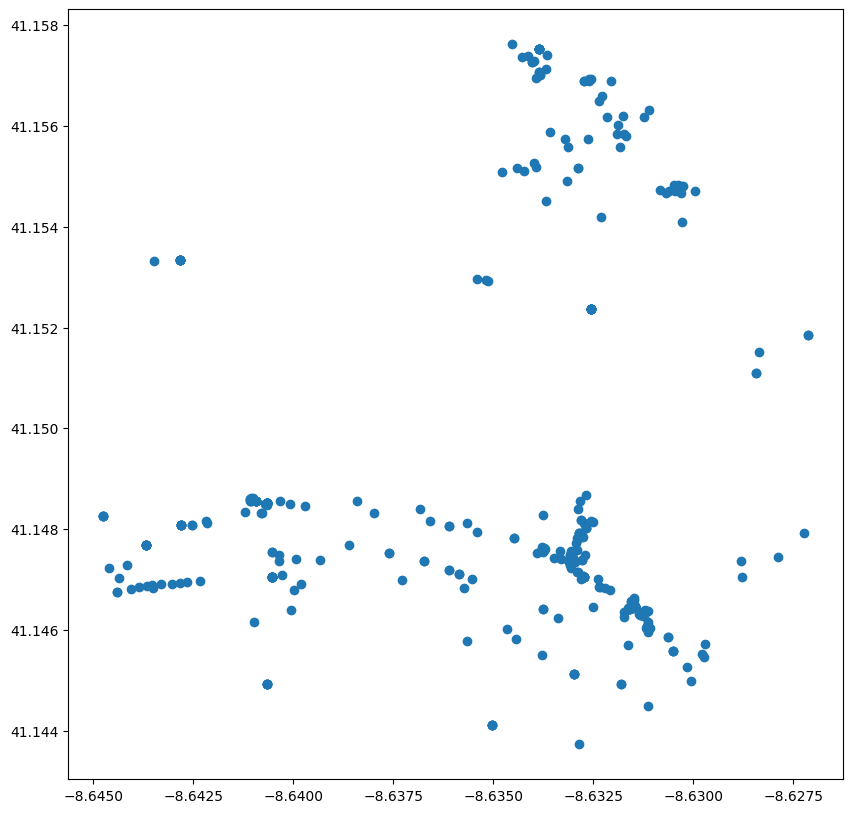

In [167]:
plt.figure(figsize=(10,10))
plt.scatter(img_df['lon'],img_df['lat'])

You can already observe that the distribution of collected posts are scattering around the area, if you are familiar enough. It will be more readable if being overlaid with the real urban network from Open Street Map.

In [144]:
tags= tags={'amenity': True, 'highway':True, 'landuse':True, 'building':True, 'waterway': True, 'railway': True}
all_geom=ox.features.features_from_point((args.lat, args.lon),  tags, dist=args.radius * 1500)
#all_geom = all_geom.to_crs(epsg=3857)

In [156]:
G = ox.graph_from_point((args.lat, args.lon), dist=args.radius * 1500, network_type='all')
G_proj = ox.projection.project_graph(G, to_latlong=True)

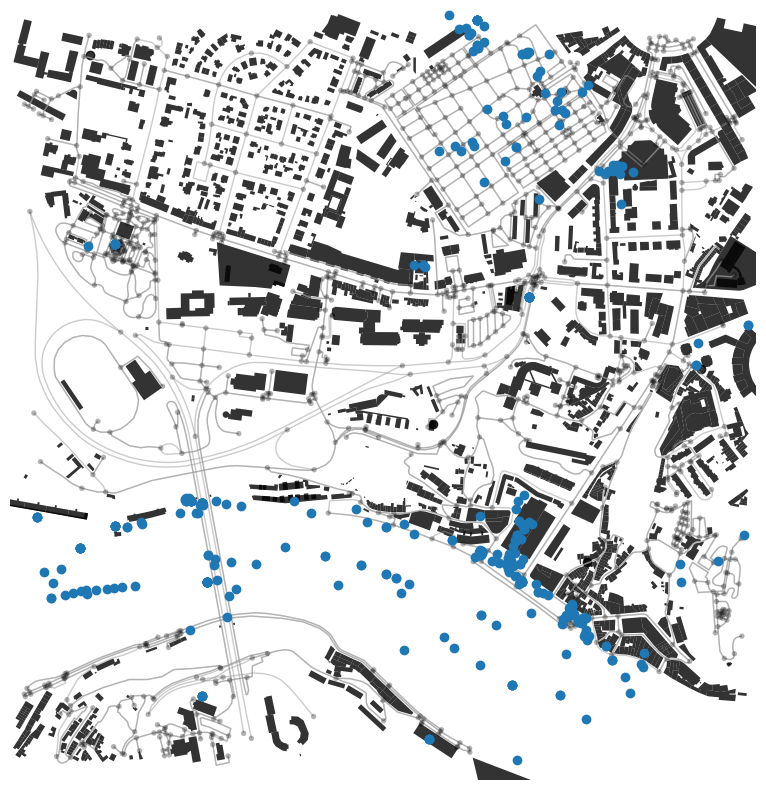

In [165]:
fig,ax = plt.subplots(figsize=(10,10))
all_geom[all_geom['building'].notna()].plot(ax=ax,color='black', alpha=0.8)
ox.plot_graph(G_proj, figsize=(10, 10), bgcolor='w', node_color='k', node_alpha = 0.3, edge_alpha = 0.5, ax=ax, show=False)

ax.scatter(img_df['lon'],img_df['lat'])
plt.axis('off')
plt.show()

#### Temporal Distribution

In [168]:
img_df['date'] = img_df['taken'].apply(lambda x: int(x[:4]))

In [169]:
img_df['date'].describe()

count     400.00000
mean     2020.64000
std         6.62761
min      1960.00000
25%      2022.00000
50%      2023.00000
75%      2023.00000
max      2023.00000
Name: date, dtype: float64

<Axes: >

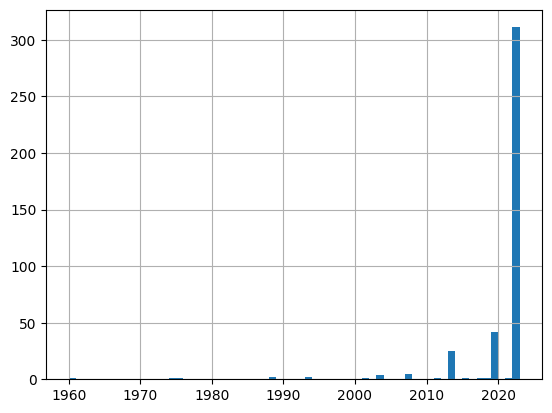

In [179]:
img_df['date'].hist(bins=img_df['date'].max() - img_df['date'].min())

#### Preprocessing of Textual Information

A subset that has textual information of Description, Title, and Tags

In [180]:
img_df['tag_list'] = img_df['tags'].apply(lambda x: re.findall(r'_content\': \'([a-zA-Z]+)',x))
img_df['tag_len'] = img_df['tag_list'].apply(lambda x: len(x))

In [77]:
df_new = img_df[~((img_df['description'].isnull())|(img_df['title'].isnull())|(img_df['tag_len']==0))]
df_new

,ids,candownload,url_q,owner,owner_loc,title,description,comments,taken,views,people,tags,lat,lon,neighbourhood,url,tag_list,tag_len,date
0,53440346026,0,https://live.staticflickr.com/65535/5344034602...,48597791@N04,NaN,Tram 131 at Massarelos,Porto,0,2023-05-13 18:42:17,82,0,"[{'id': '48565652-53440346026-32298', 'author'...",41.147397,-8.633303,Massarelos,https://www.flickr.com/photos/ernstkers/534403...,"[streetcar, trolley, strasenbahn, stcp, tram, ...",14,2023
1,53435181869,0,https://live.staticflickr.com/65535/5343518186...,48597791@N04,NaN,Museum horse tram 8 at Arrábida,Annual Porto museumtrams parade of 2023,0,2023-05-13 15:49:09,164,0,"[{'id': '48565652-53435181869-32298', 'author'...",41.148547,-8.641056,NaN,https://www.flickr.com/photos/ernstkers/534351...,"[streetcar, trolley, strasenbahn, stcp, tram, ...",16,2023
2,53424054099,0,https://live.staticflickr.com/65535/5342405409...,48597791@N04,NaN,Zorra 58 at Massarelos,At the end of the annual Porto museumtrams par...,0,2023-05-13 17:44:15,231,0,"[{'id': '48565652-53424054099-32298', 'author'...",41.147552,-8.633748,Massarelos,https://www.flickr.com/photos/ernstkers/534240...,"[streetcar, trolley, strasenbahn, zorra, stcp,...",15,2023
3,53417600202,0,https://live.staticflickr.com/65535/5341760020...,48597791@N04,NaN,Museumtram 100 at Arrábida,Annual Porto museumtrams parade of 2023,0,2023-05-13 15:50:00,148,0,"[{'id': '48565652-53417600202-32298', 'author'...",41.148613,-8.641064,NaN,https://www.flickr.com/photos/ernstkers/534176...,"[streetcar, trolley, strasenbahn, stcp, tram, ...",14,2023
4,53413760498,0,https://live.staticflickr.com/65535/5341376049...,48597791@N04,NaN,Musemtram 104 at Massarelos,In advance of the 2023 Porto annual museum tra...,0,2023-05-13 14:39:21,165,0,"[{'id': '48565652-53413760498-32298', 'author'...",41.145961,-8.631125,Massarelos,https://www.flickr.com/photos/ernstkers/534137...,"[streetcar, trolley, strasenbahn, tram, sp, bo...",14,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,52618128452,0,https://live.staticflickr.com/65535/5261812845...,48597791@N04,NaN,Tram no.216 ascends Rua da Restauração,"Massarelos, Porto",1,2022-05-05 12:52:48,304,0,"[{'id': '48565652-52618128452-32298', 'author'...",41.146377,-8.631145,Massarelos,https://www.flickr.com/photos/ernstkers/526181...,"[streetcar, trolley, tram, stcp, bonde, brill,...",15,2022
395,52588253407,0,https://live.staticflickr.com/65535/5258825340...,48597791@N04,NaN,Tram 104 at Arrabida,Annual tram parade of 2022.,0,2022-05-15 16:42:33,434,0,"[{'id': '48565652-52588253407-32298', 'author'...",41.148550,-8.640931,NaN,https://www.flickr.com/photos/ernstkers/525882...,"[streetcar, trolley, mce, lightrail, tram, stc...",17,2022
397,52572113650,1,https://live.staticflickr.com/65535/5257211365...,167400908@N08,"Montréal, Canada",Portugal - Porto,Cemitério de Agramonte,21,2022-09-28 05:06:27,11058,0,"[{'id': '167308095-52572113650-13575254', 'aut...",41.156195,-8.631767,NaN,https://www.flickr.com/photos/gaetanbois/52572...,"[cemit, landscape, urban, bw, blackandwhite, p...",9,2022
398,52571897389,0,https://live.staticflickr.com/65535/5257189738...,127635832@N07,"Vila Nova de Gaia, Portugal",Favolaschia calocera,Fungos do Bosque...\n\nPorto | Portugal\n\nMui...,2,2022-12-18 17:59:22,3235,0,"[{'id': '127614502-52571897389-280158', 'autho...",41.153349,-8.642828,Lordelo do Ouro,https://www.flickr.com/photos/mamarocarvalho/5...,"[fungo, fungos, fungi, favolaschiacalocera]",4,2022
